# Big Mac Price Analysis



Analysis of Big Mac price variation over time across different countries worldwide.

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

from IPython.display import display

plt.style.use('ggplot')

def plot_multiple_lines(df: pd.DataFrame, x: str, y: str, group: str, xlabel: str, ylabel: str):
    '''
        This function accepts a Pandas Dataframe and creates a multiple line plot of "x" vs "y" (where "x" and "y" are two
        columns), where lines are defined by "group". 
    
    Args:
        df (Pandas Dataframe): an input Pandas DataFrame
        x (str): name of the column defining the x axis
        y (str): name of the column defining the y axis
        group (str): name of the column defining the variable to group by
        xlabel (str): x-axis label name
        ylabel (str): y-axis label name

    Returns:
        plot: line plot
    '''
    
    # Define a color list:
    color_list = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", "#7c1158"]

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_prop_cycle(color=[x for x in color_list])

    # Set index to x
    df.set_index(x, inplace=True)
    
    # Build multiple line plot with customized style
    plot = df.groupby(group)[y].plot(legend=True, xlabel=xlabel, ylabel=ylabel, marker='o', linewidth=2.5)
    plt.legend(edgecolor='black')

    return plot
    


bigmac = pd.read_csv("./BigmacPrice.csv")

# Print information about the dataset 
print(bigmac.shape)
print(bigmac.columns)

(1946, 6)
Index(['date', 'currency_code', 'name', 'local_price', 'dollar_ex',
       'dollar_price'],
      dtype='object')


The Big Mac dataset consists of **1946** rows and **6** columns. These are: *date*, *currency_code*, *name*, *local_price*, *dollar_ex* and *dollar_price*. According to the author's description available on Kaggle, *dollar_ex* is the US dollar conversion rate, namely:

$$ \frac{\text{local price}}{\text{dollar ex}} = \text{dollar price} $$

## Cleaning 

Perform some cleaning operations

In [292]:
# Check if dataset contains NA 
print(bigmac.isna().any())

date             False
currency_code    False
name             False
local_price      False
dollar_ex        False
dollar_price     False
dtype: bool


There are no NA values in the dataset. However, some rows may have vanishing local_price or dollar_price , which is clearly unreasonable. Let find such rows and remove them from the Pandas dataframe: 

In [293]:
# Find rows with vanishing local_price or dollar_price 
display(bigmac[(bigmac["local_price"]==0) | (bigmac["dollar_price"]==0)])

# Remove rows with vanishing local_price or dollar_price
bigmac = bigmac[(bigmac["local_price"]!=0) | (bigmac["dollar_price"]!=0)]

,date,currency_code,name,local_price,dollar_ex,dollar_price
1296,2018-01-01,VEF,Venezuela,0.0,1,0.0


In [294]:
# Convert "date" to datetime column
bigmac["date"] =  pd.to_datetime(bigmac["date"], infer_datetime_format=True)
display(bigmac.head(5))

,date,currency_code,name,local_price,dollar_ex,dollar_price
0,2000-04-01,ARS,Argentina,2.50,1,2.50
1,2000-04-01,AUD,Australia,2.59,1,2.59
2,2000-04-01,BRL,Brazil,2.95,1,2.95
3,2000-04-01,GBP,Britain,1.90,1,1.90
4,2000-04-01,CAD,Canada,2.85,1,2.85


## Explanatory Data Analysis

Let start by doing some *explarotory data analysys* (EDA). The dataset contains a *date* column, so we should first check the extent of data in time:

In [295]:
# Check number of distinct date
distinct_date = bigmac["date"].nunique()
print(f"The number of distinct date in the date column is: {distinct_date}")

# Find min and max date:
min_date = bigmac["date"].min()
max_date = bigmac["date"].max()
print(f"Minimum date: {min_date}    Maximum date: {max_date}")

The number of distinct date in the date column is: 37
Minimum date: 2000-04-01 00:00:00    Maximum date: 2022-07-01 00:00:00


There are 37 distinct date, ranging from 2000-04-01 to 2022-07-01. We may not have the same data for each country at the same date. To check it, let first briefly analyze the number of distinct countries available in the dataset:

In [296]:
# Check number of distinct country
distinct_country = bigmac["name"].nunique()
print(f"The number of distinct countries in the date column is: {distinct_country}")

The number of distinct countries in the date column is: 74


Since $74\times 37 = 2738 > 1946$, for some countries we have less than 37 data point. To better understand the distribution of collected data among countries, we may plot the dollar price vs date, using different colors for each country. Let generate two different line plots, one visualizing the top 10 countries by data points in time and one for the bottom 10. 

name
Croatia      AxesSubplot(0.125,0.2;0.775x0.68)
Honduras     AxesSubplot(0.125,0.2;0.775x0.68)
Jordan       AxesSubplot(0.125,0.2;0.775x0.68)
Kuwait       AxesSubplot(0.125,0.2;0.775x0.68)
Latvia       AxesSubplot(0.125,0.2;0.775x0.68)
Lebanon      AxesSubplot(0.125,0.2;0.775x0.68)
Moldova      AxesSubplot(0.125,0.2;0.775x0.68)
Nicaragua    AxesSubplot(0.125,0.2;0.775x0.68)
Oman         AxesSubplot(0.125,0.2;0.775x0.68)
Romania      AxesSubplot(0.125,0.2;0.775x0.68)
Name: dollar_price, dtype: object

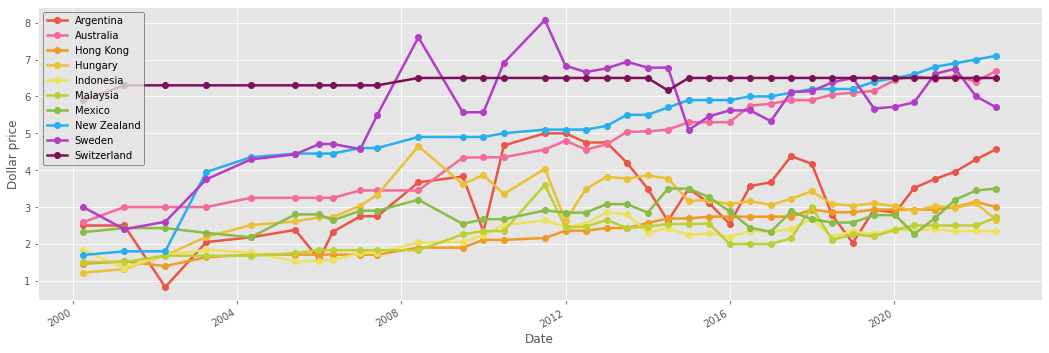

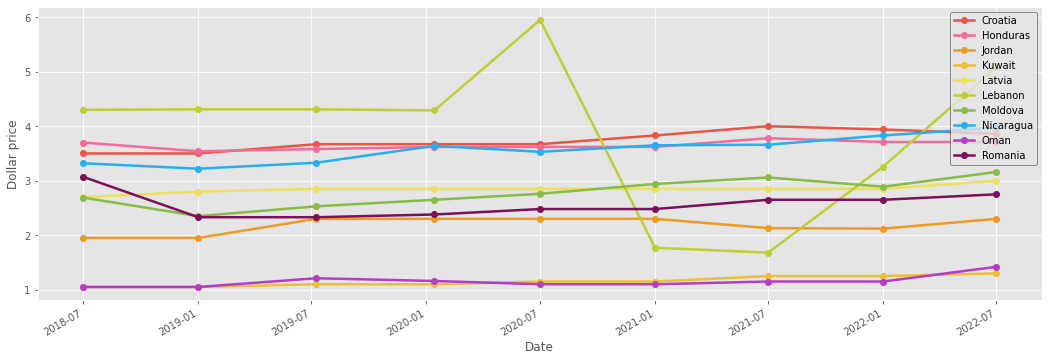

In [297]:

# Count unique date for each country
country_ndate = bigmac.groupby("name")["date"].nunique()

# Create a new Pandas dataframe with top 10 countries by date data collected
top10_country_ndate = country_ndate.sort_values(ascending=False).head(10).to_frame().reset_index()
bigmac_top10_country_ndate = bigmac[bigmac["name"].isin(top10_country_ndate["name"])]

# Create a new Pandas dataframe with bottom 10 countries by date data collected
bottom10_country_ndate = country_ndate.sort_values(ascending=True).head(10).to_frame().reset_index()
bigmac_bottom10_country_ndate = bigmac[bigmac["name"].isin(bottom10_country_ndate["name"])]

# Plot date vs dollar price for top 10 and bottom 10 countries by date date collected
plot_multiple_lines(bigmac_top10_country_ndate, "date", "dollar_price", "name", "Date", "Dollar price")
plot_multiple_lines(bigmac_bottom10_country_ndate, "date","dollar_price", "name", "Date", "Dollar price")


According to this dataset, Big Mac price of countries such as Argentina, Australia, Hong Kong and many others have been recorded since 2000, while for other countries, such as Croatia, Kuwait, Jordan, etc, we just have recent data from 2018.

In [298]:
# Calculate max and min price ever
max_price_ever = bigmac["dollar_price"].max()
min_price_ever = bigmac["dollar_price"].min()
display(bigmac[bigmac["dollar_price"].isin([max_price_ever, min_price_ever])])


,date,currency_code,name,local_price,dollar_ex,dollar_price
687,2013-01-01,BRL,Brazil,11.25,1,11.25
1016,2015-07-01,VEF,Venezuela,132.00,197,0.67
1072,2016-01-01,VEF,Venezuela,132.00,198,0.67


2022


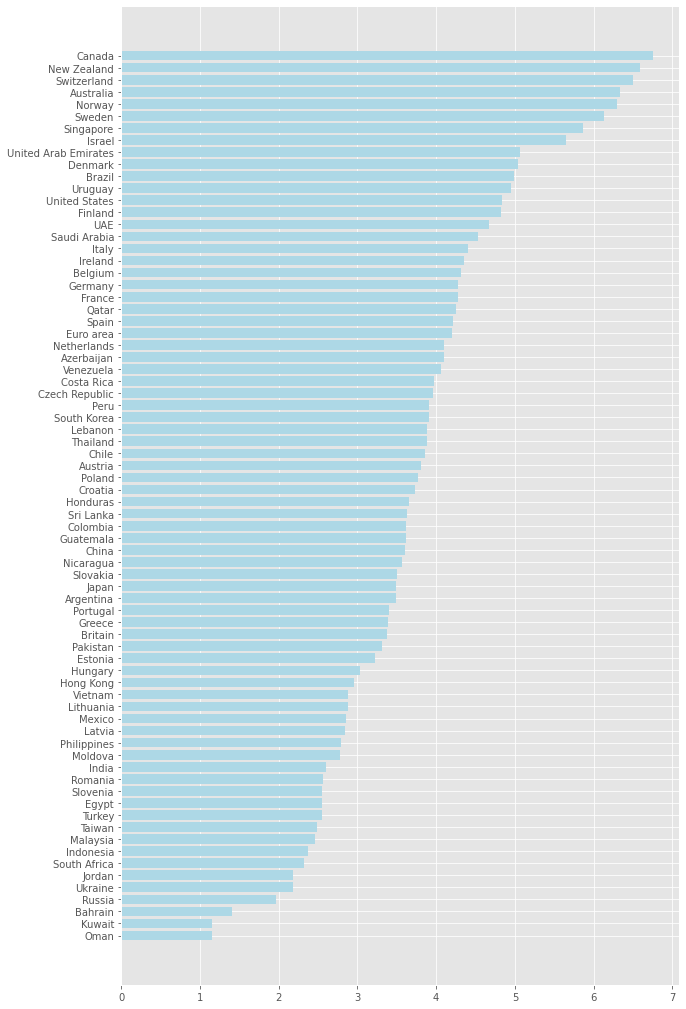

In [313]:
# Filter last 5 years
current_year = date.today().year
print(current_year)
bigmac_last_five_years = bigmac[current_year - bigmac["date"].dt.year  < 5]
#display(bigmac_last_five_years.head(5))
bigmac_avgprice = bigmac_last_five_years.groupby("name")["dollar_price"].mean().to_frame().reset_index()
# Rename dollar_price column
bigmac_avgprice = bigmac_avgprice.rename(columns={"dollar_price":"avg_dollar_price"})
# Sort by avg_dollar_price
bigmac_avgprice = bigmac_avgprice.sort_values("avg_dollar_price", ascending=False)

fig, ax = plt.subplots(figsize=(10, 18))

plt.barh(y=bigmac_avgprice["name"], width=bigmac_avgprice["avg_dollar_price"], color='lightblue')
ax.invert_yaxis()
